In [1]:
import pandas as pd

import pyteomics.mgf
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_utils as pu
import well_plate

In [2]:
def save_fig(file_name):
  plt.savefig(r"C:\git\msn_library\figures/{}.png".format(file_name), dpi=300)
  plt.savefig(r"C:\git\msn_library\figures/{}.pdf".format(file_name))
  plt.savefig(r"C:\git\msn_library\figures/{}.svg".format(file_name))

In [3]:
def read_mgf(infile) -> pd.DataFrame:
  import re
  rows = []
  counter = 0
  
  with pyteomics.mgf.MGF(infile) as f_in:
    for spectrum_dict in tqdm(f_in):
      if spectrum_dict is not None:
        rows.append(spectrum_dict["params"])
      else:
        counter += 1
  
  df = pd.DataFrame(rows)
  if "inchikey" not in df.columns:
    df["inchikey"] = df["inchiaux"]
  if "compound_name" not in df.columns:
    df["compound_name"] = df["name"]
  if "monoisotopic_mass" not in df.columns:
    df["monoisotopic_mass"] = df["exactmass"]
  #
  if "usi" in df.columns:
    df["unique_sample_id"] = ["pluskal{}_id".format(re.search(r'pluskal(.*?)_id', usi).group(1))  for usi in df["usi"]]
  return df

In [18]:
# positive_file = r"C:\git\msn_library\library\20230811_mce_library_pos_all_lib_MSn.mgf"
# negative_file = r"C:\git\msn_library\library\20231017_mce_library_neg_all_lib_MSn.mgf"
# libraryfile = r"C:\git\msn_library\data\library\mce_library_all_cleaned.tsv"

## NIH
positive_file = r"C:\git\msn_library\library\20231024_nih_library_pos_all_lib_MSn.mgf"
negative_file = r"C:\git\msn_library\library\20231024_nih_library_neg_all_lib_MSn.mgf"
libraryfile = r"C:\git\msn_library\data\nih\nih_library_new_headers_cleaned.tsv"

In [19]:
positive_df = read_mgf(positive_file)
negative_df = read_mgf(negative_file)
libdf = pu.read_dataframe(libraryfile)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\git\msn_library\pandas_utils.py:34: DtypeWarning: Columns (6,35,39,41,42,44,45,46,48,49,51,53,59,60,66,71,74,83,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep="\t")


In [17]:
libdf[libdf["unique_sample_id"] == "pluskal_nih_05P_E7"]

,MW,Platenumber,WellLetter,WellNumber,XLogP,any_phase,atc_classifications,availability,broad_disease_area,broad_indication,...,synonyms,topical,unichem_id,unichem_url,unii,unique_sample_id,usan_stem_definition,well_location,withdrawn,zinc_id
1320,572.8,17,E,7,7.5,False,NaN,NaN,NaN,NaN,...,"(2R,6R)-6-[(3R,10S,12S,13R,17R)-3-(2-Carboxyac...",NaN,24228287.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,NaN,NaN
1321,324.4,17,E,7,4.7,False,NaN,-1.0,NaN,NaN,...,(+/-)-Galabranin;Oprea1_792095;SCHEMBL320135;C...,False,46402.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,False,NaN
1322,431.6,17,E,7,2.7,False,NaN,NaN,NaN,NaN,...,"CHEBI:182477;(E,2S,3R,4R,5S)-2-Acetamido-3,4,5...",NaN,32028754.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,NaN,NaN
1323,426.4,17,E,7,2.7,False,NaN,NaN,NaN,NaN,...,NCGC00381189-01,NaN,102613590.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,NaN,ZINC000225458812
1324,300.3,17,E,7,2.1,False,NaN,-1.0,NaN,NaN,...,"Barpisoflavone A;101691-27-4;3-(2,4-DIHYDROXYP...",False,12825865.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,False,ZINC000014758993
1325,288.3,17,E,7,2.2,False,NaN,-1.0,NaN,NaN,...,Maesopsin;5989-16-2;Mesopsin;3(2H)-Benzofurano...,False,500708.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_05P_E7,NaN,E7,False,NaN
1326,442.5,17,E,7,NaN,False,NaN,NaN,NaN,NaN,...,NCGC00385383-01,NaN,NaN,NaN,NaN,pluskal_nih_05P_E7,NaN,E7,NaN,NaN


In [20]:
libdf

,MW,Platenumber,WellLetter,WellNumber,XLogP,any_phase,atc_classifications,availability,broad_disease_area,broad_indication,...,synonyms,topical,unichem_id,unichem_url,unii,unique_sample_id,usan_stem_definition,well_location,withdrawn,zinc_id
0,354.4,1,A,2,2.9,False,NaN,-1.0,NaN,NaN,...,.beta.-Yohimbine;Amberlite CG-400;NSC407306;me...,False,673503.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_01P_A2,NaN,A2,False,NaN
1,354.4,1,A,2,2.9,False,NaN,-1.0,NaN,NaN,...,.beta.-Yohimbine;Amberlite CG-400;NSC407306;me...,False,673503.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_01P_A2,NaN,A2,False,NaN
2,370.4,1,A,2,1.6,False,NaN,-1.0,NaN,NaN,...,"Paulownin;13040-46-5;(3R,3aS,6S,6aR)-3,6-bis(1...",False,618423.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_01P_A2,NaN,A2,False,ZINC000005037439
3,386.4,1,A,2,3.1,False,NaN,NaN,NaN,NaN,...,Praeruptorin A;Pd-Ia;(-)-Praeruptorin A;(10-Ac...,NaN,23624483.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_01P_A2,NaN,A2,NaN,NaN
4,717.7,1,A,2,-4.8,False,NaN,NaN,NaN,NaN,...,Ferricrocin [M-H2+Fe];SCHEMBL20203778;14-(Hydr...,NaN,22643782.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_01P_A2,NaN,A2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,NaN,50,G,12,NaN,True,NaN,-1.0,NaN,NaN,...,"parthenolide;(-)-Parthenolide;20554-84-1;(1aR,...",False,183739.0,https://www.ebi.ac.uk/unichem/compoundsources?...,2RDB26I5ZB,pluskal_nih_15P_G12,NaN,G12,False,ZINC000030726283
4382,NaN,50,G,12,NaN,False,NaN,NaN,NaN,NaN,...,"CHEBI:181695;NCGC00385912-01;2-[(1S,5S)-5-meth...",NaN,66366804.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_15P_G12,NaN,G12,NaN,ZINC000014513403
4383,NaN,50,G,12,NaN,False,NaN,NaN,NaN,NaN,...,NCGC00385919-01;NCGC00385919-01_C20H34O_2-Pent...,NaN,80453068.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_15P_G12,NaN,G12,NaN,NaN
4384,NaN,50,G,12,NaN,False,NaN,NaN,NaN,NaN,...,NCGC00385918-01;NCGC00385918-01_C18H24O5_,NaN,80453042.0,https://www.ebi.ac.uk/unichem/compoundsources?...,NaN,pluskal_nih_15P_G12,NaN,G12,NaN,NaN


In [21]:
libdf = libdf[(libdf["monoisotopic_mass"] > 114) & (libdf["plate_id"]!= "07P")].copy()
libdf_filtered = libdf.sort_values(by="none")
libdf_filtered = libdf_filtered[["unique_sample_id", "well_location", "plate_id", "monoisotopic_mass", "compound_name", "inchikey", "molecular_species", "classyfire_class", "classyfire_superclass", "npclassifier_class_results", "npclassifier_superclass_results", "npclassifier_pathway_results", "logp"]].drop_duplicates(["unique_sample_id", "inchikey"]).sort_index()
libdf_filtered

KeyError: "['classyfire_class', 'classyfire_superclass'] not in index"

In [14]:
negative_df.drop_duplicates(["inchikey", "unique_sample_id"])

,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_collision_energies,msn_precursor_mzs,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id
0,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
18,Secodihydro-hydramicromelin B,NIH,326.100168,C15H18O8,InChI=1S/C15H18O8/c1-15(21)13(19)12(23-14(15)2...,BNLUQONOBPMVBG-UHFFFAOYSA-N,COc1c(C2OC(=O)C(C)(O)C2O)cc(CCC(=O)O)c(O)c1,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,BNLUQONOBPMVBG-UHFFFAOYSA-N,Secodihydro-hydramicromelin B,326.100168,pluskal_nih_01P_A10_id
37,ACon1_001543,NIH,346.105253,C18H18O7,InChI=1S/C18H18O7/c1-7-5-12(14(20)9(3)13(7)19)...,WKHWTIZYRUWECB-UHFFFAOYSA-N,Cc1cc(C(=O)Oc2c(C)c(O)c(C(=O)O)cc2C)c(O)c(C)c1O,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,WKHWTIZYRUWECB-UHFFFAOYSA-N,ACon1_001543,346.105253,pluskal_nih_01P_A10_id
75,MEGxp0_000849,NIH,422.172939,C25H26O6,InChI=1S/C25H26O6/c1-13-14(2)30-24-19(17(12-18...,CEJSYHIZUAMEQV-RFOFMGPBSA-N,C[C@@H]1C(=O)c2c(O[C@@H]1C)c(C(CC(=O)O)c1ccccc...,-1,2,99.78,...,NaN,NaN,NaN,NaN,NaN,NaN,CEJSYHIZUAMEQV-RFOFMGPBSA-N,MEGxp0_000849,422.172939,pluskal_nih_01P_A10_id
103,CHEBI:182541,NIH,229.085127,C12H11N3O2,InChI=1S/C12H11N3O2/c13-12-15-11(16)10(17-12)5...,FGTZCVGIFPOOSE-SNVBAGLBSA-N,NC1=NC(=O)[C@@H](Cc2c[nH]c3ccccc23)O1,-1,2,60.39,...,NaN,NaN,NaN,NaN,NaN,NaN,FGTZCVGIFPOOSE-SNVBAGLBSA-N,CHEBI:182541,229.085127,pluskal_nih_01P_A5_id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85464,Pantoyl lactone glucoside,NIH,292.115818,C12H20O8,InChI=1S/C12H20O8/c1-12(2)4-18-10(17)9(12)20-1...,BFCZPWYLRHFBNO-DTJAAUDXSA-N,CC1(C)COC(=O)[C@@H]1O[C@@H]1O[C@H](CO)[C@@H](O...,-1,2,64.99,...,NaN,NaN,NaN,NaN,NaN,NaN,BFCZPWYLRHFBNO-DTJAAUDXSA-N,Pantoyl lactone glucoside,292.115818,pluskal_nih_15P_G9_id
85487,linalool glucoside,NIH,316.188589,C16H28O6,"InChI=1S/C16H28O6/c1-5-16(4,8-6-7-10(2)3)22-15...",FLXYFXDZJHWWGW-MUGRSDNVSA-N,C=CC(C)(CCC=C(C)C)O[C@@H]1O[C@H](CO)[C@@H](O)[...,-1,2,79.18,...,NaN,NaN,NaN,NaN,NaN,NaN,FLXYFXDZJHWWGW-MUGRSDNVSA-N,linalool glucoside,316.188589,pluskal_nih_15P_G6_id
85494,CHEBI:181631,NIH,402.188983,C19H30O9,"InChI=1S/C19H30O9/c1-10-6-12(22)7-18(3,9-21)19...",DXIYOCNHJLPWQM-JXPYDTCBSA-N,CC1=CC(=O)CC(C)(CO)C1(O)/C=C/C(C)O[C@@H]1O[C@H...,-1,2,72.12,...,NaN,NaN,NaN,NaN,NaN,NaN,DXIYOCNHJLPWQM-JXPYDTCBSA-N,CHEBI:181631,402.188983,pluskal_nih_15P_G6_id
85540,CHEBI:182038,NIH,420.163162,C18H28O11,InChI=1S/C18H28O11/c1-7-12-8(4-11(24-2)27-7)9(...,IZODPOCIKVLNIL-MNMYWMKCSA-N,COC(=O)C1=CO[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)...,-1,2,71.70,...,NaN,NaN,NaN,NaN,NaN,NaN,IZODPOCIKVLNIL-MNMYWMKCSA-N,CHEBI:182038,420.163162,pluskal_nih_15P_G6_id


In [15]:
negative_df.drop_duplicates(["inchikey"])


,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_collision_energies,msn_precursor_mzs,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id
0,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
18,Secodihydro-hydramicromelin B,NIH,326.100168,C15H18O8,InChI=1S/C15H18O8/c1-15(21)13(19)12(23-14(15)2...,BNLUQONOBPMVBG-UHFFFAOYSA-N,COc1c(C2OC(=O)C(C)(O)C2O)cc(CCC(=O)O)c(O)c1,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,BNLUQONOBPMVBG-UHFFFAOYSA-N,Secodihydro-hydramicromelin B,326.100168,pluskal_nih_01P_A10_id
37,ACon1_001543,NIH,346.105253,C18H18O7,InChI=1S/C18H18O7/c1-7-5-12(14(20)9(3)13(7)19)...,WKHWTIZYRUWECB-UHFFFAOYSA-N,Cc1cc(C(=O)Oc2c(C)c(O)c(C(=O)O)cc2C)c(O)c(C)c1O,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,WKHWTIZYRUWECB-UHFFFAOYSA-N,ACon1_001543,346.105253,pluskal_nih_01P_A10_id
75,MEGxp0_000849,NIH,422.172939,C25H26O6,InChI=1S/C25H26O6/c1-13-14(2)30-24-19(17(12-18...,CEJSYHIZUAMEQV-RFOFMGPBSA-N,C[C@@H]1C(=O)c2c(O[C@@H]1C)c(C(CC(=O)O)c1ccccc...,-1,2,99.78,...,NaN,NaN,NaN,NaN,NaN,NaN,CEJSYHIZUAMEQV-RFOFMGPBSA-N,MEGxp0_000849,422.172939,pluskal_nih_01P_A10_id
103,CHEBI:182541,NIH,229.085127,C12H11N3O2,InChI=1S/C12H11N3O2/c13-12-15-11(16)10(17-12)5...,FGTZCVGIFPOOSE-SNVBAGLBSA-N,NC1=NC(=O)[C@@H](Cc2c[nH]c3ccccc23)O1,-1,2,60.39,...,NaN,NaN,NaN,NaN,NaN,NaN,FGTZCVGIFPOOSE-SNVBAGLBSA-N,CHEBI:182541,229.085127,pluskal_nih_01P_A5_id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85464,Pantoyl lactone glucoside,NIH,292.115818,C12H20O8,InChI=1S/C12H20O8/c1-12(2)4-18-10(17)9(12)20-1...,BFCZPWYLRHFBNO-DTJAAUDXSA-N,CC1(C)COC(=O)[C@@H]1O[C@@H]1O[C@H](CO)[C@@H](O...,-1,2,64.99,...,NaN,NaN,NaN,NaN,NaN,NaN,BFCZPWYLRHFBNO-DTJAAUDXSA-N,Pantoyl lactone glucoside,292.115818,pluskal_nih_15P_G9_id
85487,linalool glucoside,NIH,316.188589,C16H28O6,"InChI=1S/C16H28O6/c1-5-16(4,8-6-7-10(2)3)22-15...",FLXYFXDZJHWWGW-MUGRSDNVSA-N,C=CC(C)(CCC=C(C)C)O[C@@H]1O[C@H](CO)[C@@H](O)[...,-1,2,79.18,...,NaN,NaN,NaN,NaN,NaN,NaN,FLXYFXDZJHWWGW-MUGRSDNVSA-N,linalool glucoside,316.188589,pluskal_nih_15P_G6_id
85494,CHEBI:181631,NIH,402.188983,C19H30O9,"InChI=1S/C19H30O9/c1-10-6-12(22)7-18(3,9-21)19...",DXIYOCNHJLPWQM-JXPYDTCBSA-N,CC1=CC(=O)CC(C)(CO)C1(O)/C=C/C(C)O[C@@H]1O[C@H...,-1,2,72.12,...,NaN,NaN,NaN,NaN,NaN,NaN,DXIYOCNHJLPWQM-JXPYDTCBSA-N,CHEBI:181631,402.188983,pluskal_nih_15P_G6_id
85540,CHEBI:182038,NIH,420.163162,C18H28O11,InChI=1S/C18H28O11/c1-7-12-8(4-11(24-2)27-7)9(...,IZODPOCIKVLNIL-MNMYWMKCSA-N,COC(=O)C1=CO[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)...,-1,2,71.70,...,NaN,NaN,NaN,NaN,NaN,NaN,IZODPOCIKVLNIL-MNMYWMKCSA-N,CHEBI:182038,420.163162,pluskal_nih_15P_G6_id


In [16]:
negative_df.groupby(["quality_chimeric"]).count()

,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_collision_energies,msn_precursor_mzs,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id
quality_chimeric,,,,,,,,,,,,,,,,,,,,,
CHIMERIC,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,...,880,880,880,880,54,54,1065,1065,1065,1065
MISSING_MAIN_SIGNAL,9,9,9,9,9,9,9,9,9,9,...,7,7,7,7,0,0,9,9,9,9
PASSED,83351,84495,84495,84495,84495,84495,84495,84495,84495,84495,...,67585,67585,67585,67585,2359,2359,84495,83351,84495,84495


In [17]:
negative_df

,name,description,exactmass,formula,inchi,inchiaux,smiles,feature_id,mslevel,rtinseconds,...,msn_collision_energies,msn_precursor_mzs,msn_fragmentation_methods,msn_isolation_windows,other_matched_compounds,other_matched_compounds_names,inchikey,compound_name,monoisotopic_mass,unique_sample_id
0,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
1,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,-1,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
2,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,278,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
3,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,277,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
4,CHEBI:181820,NIH,280.131074,C15H20O5,InChI=1S/C15H20O5/c1-8-4-5-10-9(2)13(17)19-12(...,IRPFOXRBPHCCTG-CZLFTNFUSA-N,C=C1C(=O)O[C@@H]2[C@H]1CC[C@H](C)[C@]1(CCC(=O)...,276,2,78.13,...,NaN,NaN,NaN,NaN,NaN,NaN,IRPFOXRBPHCCTG-CZLFTNFUSA-N,CHEBI:181820,280.131074,pluskal_nih_01P_A10_id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85564,CHEBI:182038,NIH,420.163162,C18H28O11,InChI=1S/C18H28O11/c1-7-12-8(4-11(24-2)27-7)9(...,IZODPOCIKVLNIL-MNMYWMKCSA-N,COC(=O)C1=CO[C@@H](O[C@@H]2O[C@H](CO)[C@@H](O)...,405,4,71.70,...,"[15.0, 40.0, 20.0]","[465.160064697266, 257.102203369141, 101.02435...","[HCD, HCD, HCD]","[1.2000000476840569, 2.0, 2.200000047684]",NaN,NaN,IZODPOCIKVLNIL-MNMYWMKCSA-N,CHEBI:182038,420.163162,pluskal_nih_15P_G6_id
85565,CHEBI:181872,NIH,766.450342,C41H66O13,InChI=1S/C41H66O13/c1-36(2)13-15-41(35(49)50)1...,RROGHRHLBLVQSG-HGSPITOSSA-N,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,-1,2,37.64,...,NaN,NaN,NaN,NaN,NaN,NaN,RROGHRHLBLVQSG-HGSPITOSSA-N,CHEBI:181872,766.450342,pluskal_nih_15P_G6_id
85566,CHEBI:181872,NIH,766.450342,C41H66O13,InChI=1S/C41H66O13/c1-36(2)13-15-41(35(49)50)1...,RROGHRHLBLVQSG-HGSPITOSSA-N,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,-1,2,37.64,...,NaN,NaN,NaN,NaN,NaN,NaN,RROGHRHLBLVQSG-HGSPITOSSA-N,CHEBI:181872,766.450342,pluskal_nih_15P_G6_id
85567,CHEBI:181872,NIH,766.450342,C41H66O13,InChI=1S/C41H66O13/c1-36(2)13-15-41(35(49)50)1...,RROGHRHLBLVQSG-HGSPITOSSA-N,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,-1,2,37.64,...,NaN,NaN,NaN,NaN,NaN,NaN,RROGHRHLBLVQSG-HGSPITOSSA-N,CHEBI:181872,766.450342,pluskal_nih_15P_G6_id


In [7]:
filtered_positive = positive_df.drop_duplicates(["inchikey", "unique_sample_id"])
filtered_negative =  negative_df.drop_duplicates(["inchikey", "unique_sample_id"])


In [146]:
mapper = {
  "left_only": "positive",
  "right_only": "negative",
  "both": "both",
}

detect = {
  "left_only": "missing",
  "right_only": "error",
  "both": "detected",
}

dfs = []

for df in [filtered_positive, filtered_negative]:
  df = df[["inchikey", "unique_sample_id"]].drop_duplicates(["unique_sample_id", "inchikey"]).set_index(
      ["unique_sample_id", "inchikey"])
  dfs.append(df)

outer = pd.merge(dfs[0], dfs[1], indicator="exist", how="outer", left_index=True,
                 right_index=True, suffixes=("", "_data")).reset_index()
df_diff_filtered = pd.merge(libdf_filtered, outer, how="left", on=["unique_sample_id", "inchikey"], indicator="detected")
# df_diff_filtered = df_diff_filtered[["unique_sample_id", "inchikey", "exist", "smiles", "well_location", "plate_id"]]
df_diff_filtered["exist"] = [mapper.get(ex, "missing") for ex in df_diff_filtered["exist"]]
df_diff_filtered["detected"] = [detect.get(ex, "") for ex in df_diff_filtered["detected"]]
df_diff_filtered

,unique_sample_id,well_location,plate_id,monoisotopic_mass,compound_name,inchikey,molecular_species,classyfire_class,classyfire_superclass,npclassifier_class_results,npclassifier_superclass_results,npclassifier_pathway_results,logp,exist,detected
0,pluskal_nih_01P_A2_id,A2,01P,354.194343,.beta.-Yohimbine,BLGXFZZNTVWLAY-UHFFFAOYSA-N,NEUTRAL,Yohimbine alkaloids,Alkaloids and derivatives,Yohimbine-like alkaloids,Tryptophan alkaloids,Alkaloids,2.6471,both,detected
1,pluskal_nih_01P_A2_id,A2,01P,370.105253,Paulownin,CAQZFLPWHBKTTR-WNISUXOKSA-N,NEUTRAL,Furanoid lignans,"Lignans, neolignans and related compounds",Furofuranoid lignans,Lignans,Shikimates and Phenylpropanoids,2.3341,missing,missing
2,pluskal_nih_01P_A2_id,A2,01P,386.136553,Praeruptorin A,XGPBRZDOJDLKOT-NXIDYTHLSA-N,NEUTRAL,Coumarins and derivatives,Phenylpropanoids and polyketides,Pyranocoumarins;Simple coumarins,Coumarins,Shikimates and Phenylpropanoids,3.4462,positive,detected
3,pluskal_nih_01P_A2_id,A2,01P,717.329333,Ferricrocin [M-H2+Fe],JXJRJDNSPWNZOK-UHFFFAOYSA-N,NaN,Carboxylic acids and derivatives,Organic acids and derivatives,Cyclic peptides,Oligopeptides,Amino acids and Peptides,-4.7824,negative,detected
4,pluskal_nih_01P_A2_id,A2,01P,364.261360,NaN,GFDOSVZSTRYXMK-UHFFFAOYSA-N,NaN,Prenol lipids,Lipids and lipid-like molecules,Phytane diterpenoids,Diterpenoids,Terpenoids,4.6400,missing,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3983,pluskal_nih_15P_G12_id,G12,15P,248.141244,parthenolide,KTEXNACQROZXEV-PVLRGYAZSA-N,NEUTRAL,Prenol lipids,Lipids and lipid-like molecules,Germacrane sesquiterpenoids,Sesquiterpenoids,Terpenoids,2.7620,missing,missing
3984,pluskal_nih_15P_G12_id,G12,15P,250.156895,CHEBI:181695,NIQIMYXBAQAIAT-HZMBPMFUSA-N,NaN,Prenol lipids,Lipids and lipid-like molecules,Bisabolane sesquiterpenoids,Sesquiterpenoids,Terpenoids,3.3590,negative,detected
3985,pluskal_nih_15P_G12_id,G12,15P,290.260966,NCGC00385919-01,NERNKRPBSOBEHC-PTNGSMBKSA-N,NaN,Prenol lipids,Lipids and lipid-like molecules,Labdane diterpenoids;Norlabdane diterpenoids,Diterpenoids,Terpenoids,5.5040,missing,missing
3986,pluskal_nih_15P_G12_id,G12,15P,320.162374,NCGC00385918-01,PAZOLAPVCOLMKJ-UHFFFAOYSA-N,NaN,Prenol lipids,Lipids and lipid-like molecules,Eudesmane sesquiterpenoids,Sesquiterpenoids,Terpenoids,2.9004,missing,missing


In [115]:
df_diff_filtered.groupby(["exist"]).count()

,unique_sample_id,well_location,plate_id,inchikey,molecular_species,classyfire_class,classyfire_superclass,npclassifier_class_results,npclassifier_superclass_results,npclassifier_pathway_results,logp,detected
exist,,,,,,,,,,,,
,722,722,722,722,185,689,689,648,663,701,722,722
both,1661,1661,1661,1661,312,1617,1623,1471,1497,1590,1661,1661
negative,936,936,936,936,226,900,904,829,856,903,936,936
positive,669,669,669,669,191,653,658,594,617,655,669,669


In [20]:
libdf_filtered["unique_sample_id"].value_counts()

pluskal_nih_09P_A10_id    8
pluskal_nih_11P_A5_id     8
pluskal_nih_12P_A8_id     8
pluskal_nih_12P_A7_id     8
pluskal_nih_12P_A6_id     8
                         ..
pluskal_nih_01P_A8_id     4
pluskal_nih_04P_G8_id     4
pluskal_nih_04P_C3_id     4
pluskal_nih_01P_C8_id     2
pluskal_nih_15P_A10_id    2
Name: unique_sample_id, Length: 530, dtype: int64

In [56]:
counts = df_diff_filtered[["unique_sample_id", "exist"]].value_counts()

counts
# df_counts = pd.DataFrame({'unique_sample_id': counts.index, 'count': counts.values})
# df_counts

unique_sample_id        exist   
pluskal_nih_14P_A2_id   missing     8
pluskal_nih_13P_C3_id   both        7
pluskal_nih_15P_G2_id   both        7
pluskal_nih_13P_G6_id   both        7
pluskal_nih_12P_A11_id  both        7
                                   ..
pluskal_nih_10P_A4_id   missing     1
pluskal_nih_06P_E7_id   missing     1
pluskal_nih_12P_G6_id   missing     1
pluskal_nih_04P_E4_id   missing     1
pluskal_nih_09P_A9_id   positive    1
Length: 1783, dtype: int64

In [135]:
df = pd.crosstab(df_diff_filtered.unique_sample_id, df_diff_filtered.exist)

In [136]:
df

exist,both,missing,negative,positive
unique_sample_id,,,,
pluskal_nih_01P_A10_id,2,2,2,1
pluskal_nih_01P_A11_id,3,0,2,2
pluskal_nih_01P_A12_id,4,1,0,0
pluskal_nih_01P_A2_id,2,2,1,2
pluskal_nih_01P_A3_id,5,1,0,2
...,...,...,...,...
pluskal_nih_15P_G5_id,4,1,2,1
pluskal_nih_15P_G6_id,3,4,1,0
pluskal_nih_15P_G7_id,1,4,1,2


array([<AxesSubplot:ylabel='pluskal_nih_01P_A10_id'>,
       <AxesSubplot:ylabel='pluskal_nih_01P_A11_id'>,
       <AxesSubplot:ylabel='pluskal_nih_01P_A12_id'>,
       <AxesSubplot:ylabel='pluskal_nih_01P_A2_id'>,
       <AxesSubplot:ylabel='pluskal_nih_01P_A3_id'>], dtype=object)

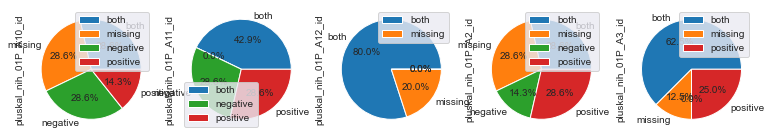

In [132]:
filename = "piechart_test_pos_neg"

# fig, axs = plt.subplots(1, 5)
df.T.plot.pie(subplots=True, figsize=(13,9), autopct='%1.1f%%')

# save_fig(filename)

KeyError: 0

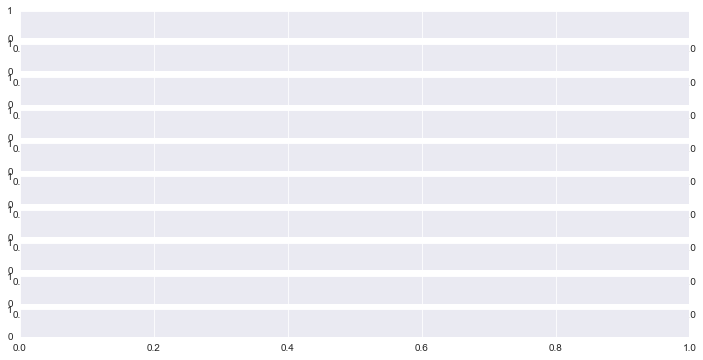

In [115]:
fig, axs = plt.subplots(10, figsize=(12,6))
i=0
for i in range(len(df)):
  axs[i].pie([df[i], sum(df)-df[i]], labels=['Data '+str(i+1), 'Other Data'], autopct='%1.1f%%')

In [139]:
libdf[libdf["unique_sample_id"] == "pluskal_nih_15P_E2_id"][["formula", "monoisotopic_mass", "input_name", "compound_name", "molecular_species", "logp", "classyfire_direct_parent", "classyfire_superclass", "inchi", "natural_product"]]

,formula,monoisotopic_mass,input_name,compound_name,molecular_species,logp,classyfire_direct_parent,classyfire_superclass,inchi,natural_product
4210,C15H22O2,234.161980,"NCGC00169782-02_C15H22O2_(2E)-5-(2,3-Dimethylt...","(E)-5-((1R,3R,6S)-2,3-Dimethyltricyclo[2.2.1.0...",ACID,3.4797,Sesquiterpenoids,Lipids and lipid-like molecules,InChI=1S/C15H22O2/c1-9(13(16)17)5-4-6-14(2)10-...,0.0
4211,C15H20O3,248.141244,"NCGC00385922-01_C15H20O3_(2R,5S,9R,12R)-13,13-...",CHEBI:181561,NaN,2.1909,Diterpenoids,Lipids and lipid-like molecules,InChI=1S/C15H20O3/c1-14(2)7-15-9-4-3-8(14)10(1...,NaN
4212,C15H22O3,250.156895,"NCGC00385921-01_C15H22O3_3a-Hydroxy-3,5a,9-tri...",SCHEMBL12904616,NaN,2.5795,"Eudesmanolides, secoeudesmanolides, and deriva...",Lipids and lipid-like molecules,InChI=1S/C15H22O3/c1-9-5-4-6-14(3)7-8-15(17)10...,NaN
4213,C15H18O4,262.120509,"NCGC00385924-01_C15H18O4_(3aS,10aR,10bR)-6,10a...",Psilostachyin B,NaN,2.2902,Ambrosanolides and secoambrosanolides,Lipids and lipid-like molecules,InChI=1S/C15H18O4/c1-8-4-5-10-9(2)14(17)18-13(...,NaN
4214,C15H22O4,266.151809,"NCGC00385923-01_C15H22O4_2-[(1E,3E)-1,3-Hexadi...",CHEBI:181366,NaN,2.1481,Furanones,Organoheterocyclic compounds,InChI=1S/C15H22O4/c1-4-5-6-7-8-15(2)14(17)10-1...,NaN
4215,C20H32O,288.245316,"NCGC00179780-02_C20H32O_(5xi,9xi)-Beyer-15-en-...",MEGxp0_001615,NaN,4.9478,Diterpenoids,Lipids and lipid-like molecules,"InChI=1S/C20H32O/c1-17-9-5-16-19(3)8-4-7-18(2,...",NaN
4216,C20H32O2,304.240230,"NCGC00180707-03_C20H32O2_1(4H)-Naphthalenone, ...","13-Hydroxy-7,14-labdadien-6-one",NaN,4.6814,Diterpenoids,Lipids and lipid-like molecules,"InChI=1S/C20H32O2/c1-7-19(5,22)12-9-15-14(2)13...",NaN
4217,C20H22N2O2,322.168128,"NCGC00385920-01_C20H22N2O2_2H-2,7a-Methanoindo...",CHEBI:181709,NaN,2.8538,Akuammilan and related alkaloids,Alkaloids and derivatives,InChI=1S/C20H22N2O2/c1-3-12-11-22-9-8-20-14-6-...,NaN


In [148]:
df_diff_filtered[df_diff_filtered["unique_sample_id"] == "pluskal_nih_15P_E2_id"][["monoisotopic_mass", "exist"]]

,monoisotopic_mass,exist
3812,234.161980,missing
3813,248.141244,missing
3814,250.156895,missing
3815,262.120509,positive
3816,266.151809,missing
3817,288.245316,missing
3818,304.240230,missing
3819,322.168128,positive


In [59]:
libdf.groupby("unique_sample_id").count()

,MW,NCGC_ID,Platenumber,WellLetter,WellNumber,XLogP,any_phase,atc_classifications,availability,broad_disease_area,...,synonyms,topical,unichem_id,unichem_url,unii,usan_stem_definition,well_location,withdrawn,zinc_id,logp
unique_sample_id,,,,,,,,,,,,,,,,,,,,,
pluskal_nih_01P_A10_id,7,7,7,7,7,7,7,0,0,0,...,7,0,7,7,0,0,7,0,1,7
pluskal_nih_01P_A11_id,7,7,7,7,7,7,7,0,2,0,...,6,2,7,7,0,0,7,2,2,7
pluskal_nih_01P_A12_id,6,6,6,6,6,6,6,0,0,0,...,5,0,6,6,0,0,6,0,1,6
pluskal_nih_01P_A2_id,8,8,8,8,8,8,8,0,4,0,...,7,4,8,8,0,0,8,4,2,8
pluskal_nih_01P_A3_id,8,8,8,8,8,8,8,0,4,0,...,8,4,8,8,1,0,8,4,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pluskal_nih_15P_G5_id,0,8,8,8,8,0,8,0,1,0,...,8,1,8,8,1,0,8,1,4,8
pluskal_nih_15P_G6_id,0,8,8,8,8,0,8,0,1,0,...,8,1,8,8,1,0,8,1,2,8
pluskal_nih_15P_G7_id,0,8,8,8,8,0,8,0,2,0,...,8,2,8,8,1,0,8,2,3,8


## Visualization of comparing negative and positive

In [119]:
file_name = "detected"

plt.figure(figsize=(13, 9))

plt.pie(df_diff_filtered(["detected"]))

TypeError: 'DataFrame' object is not callable

<Figure size 936x648 with 0 Axes>

## How to make well plates with piecharts

In [77]:
test = libdf_filtered[(libdf_filtered["plate_id"] == "01P")].set_index("well_location")

In [78]:
test

,unique_sample_id,plate_id,logp
well_location,,,
A2,pluskal_nih_01P_A2_id,01P,2.64710
A3,pluskal_nih_01P_A3_id,01P,-2.16410
A4,pluskal_nih_01P_A4_id,01P,0.80750
A5,pluskal_nih_01P_A5_id,01P,3.64040
A6,pluskal_nih_01P_A6_id,01P,1.96940
A7,pluskal_nih_01P_A7_id,01P,4.62360
A8,pluskal_nih_01P_A8_id,01P,1.77490
A9,pluskal_nih_01P_A9_id,01P,3.81340
A10,pluskal_nih_01P_A10_id,01P,4.78270


In [83]:
wp = well_plate.WellPlate(96, "circle")
wp.add_data(test["logp"])
wp.plot(key="logp")
# wp.heatmap(key="logp")